In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 4
ROOT_DIR = '/kaggle/input/parasitized/Parasitized'

In [3]:
class MalariaDataset(Dataset):
    def __init__(self, image_files, root_dir, transform=None):
        self.image_files = image_files
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        mask_name = img_name.replace('.png', '_mask.png')
        mask_path = os.path.join(self.root_dir, mask_name)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Mask as grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

all_image_files = [f for f in os.listdir(ROOT_DIR) if f.endswith('.png') and '_mask' not in f]

# Split into train and test sets
train_files, test_files = train_test_split(all_image_files, test_size=0.2, random_state=42)

# Create datasets
train_dataset = MalariaDataset(train_files, ROOT_DIR, transform=transform)
test_dataset = MalariaDataset(test_files, ROOT_DIR, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Training batch - images shape: torch.Size([4, 3, 128, 128]), masks shape: torch.Size([4, 1, 128, 128])


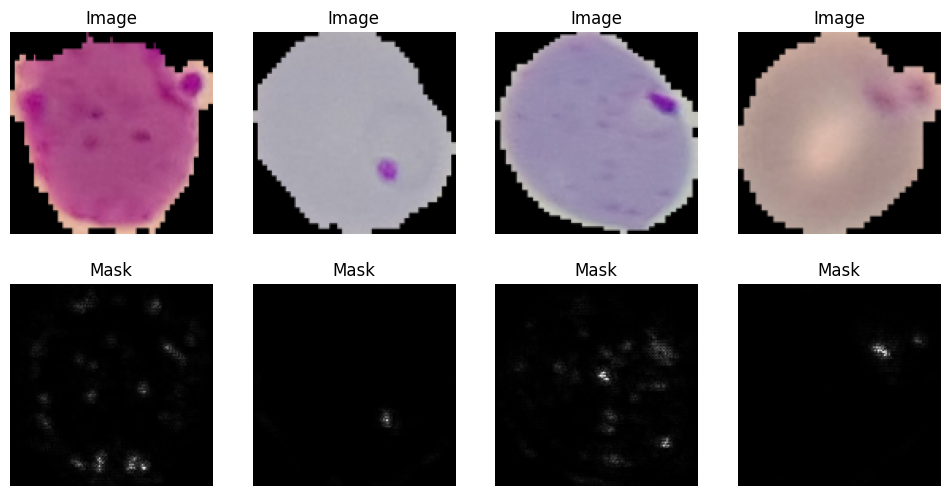

Testing batch - images shape: torch.Size([4, 3, 128, 128]), masks shape: torch.Size([4, 1, 128, 128])


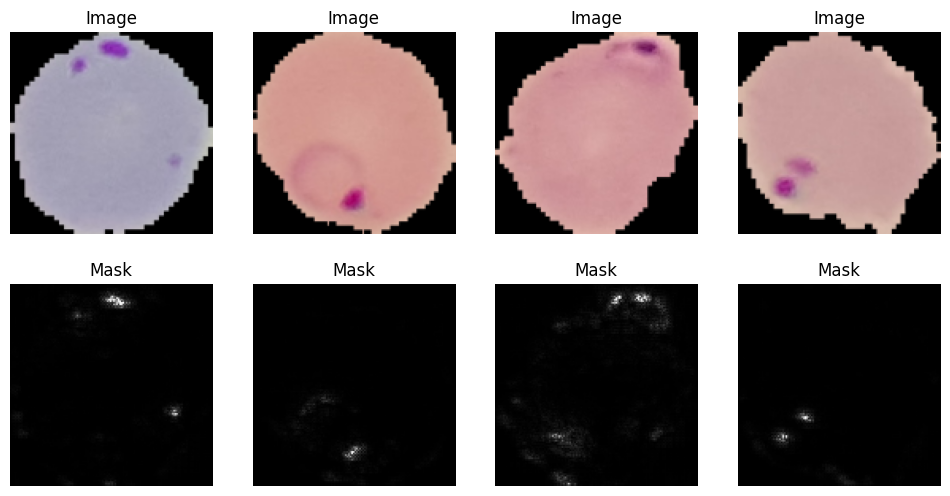

In [5]:

# Function to display images and masks
def show_images(images, masks):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(4):
        axes[0, i].imshow(images[i].permute(1, 2, 0))
        axes[0, i].set_title('Image')
        axes[0, i].axis('off')
        axes[1, i].imshow(masks[i][0], cmap='gray')
        axes[1, i].set_title('Mask')
        axes[1, i].axis('off')
    plt.show()

# Get a batch of images and masks from the training set
train_iter = iter(train_loader)
train_images, train_masks = next(train_iter)
print(f"Training batch - images shape: {train_images.shape}, masks shape: {train_masks.shape}")
show_images(train_images, train_masks)

# Get a batch of images and masks from the testing set
test_iter = iter(test_loader)
test_images, test_masks = next(test_iter)
print(f"Testing batch - images shape: {test_images.shape}, masks shape: {test_masks.shape}")
show_images(test_images, test_masks)

In [6]:
# Print the number of batches in the train and test loaders
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

Number of batches in train loader: 2756
Number of batches in test loader: 689


# Model Creation

In [7]:
""" Parts of the Attention U-Net model """


import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class AttentionUp(nn.Module):
    """Upscaling with Attention Gate"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super(AttentionUp, self).__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
        
        self.att = AttentionGate(F_g=out_channels, F_l=in_channels // 2, F_int=out_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = F.pad(x1, [0, x2.size()[3] - x1.size()[3], 0, x2.size()[2] - x1.size()[2]])
        x2 = self.att(x2, x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class AttentionUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(AttentionUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = AttentionUp(1024, 512 // factor, bilinear)
        self.up2 = AttentionUp(512, 256 // factor, bilinear)
        self.up3 = AttentionUp(256, 128 // factor, bilinear)
        self.up4 = AttentionUp(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits   

    def save_checkpoint(self, optimizer, epoch, path):
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, path)

    def load_checkpoint(self, optimizer, path):
        checkpoint = torch.load(path)
        self.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch']

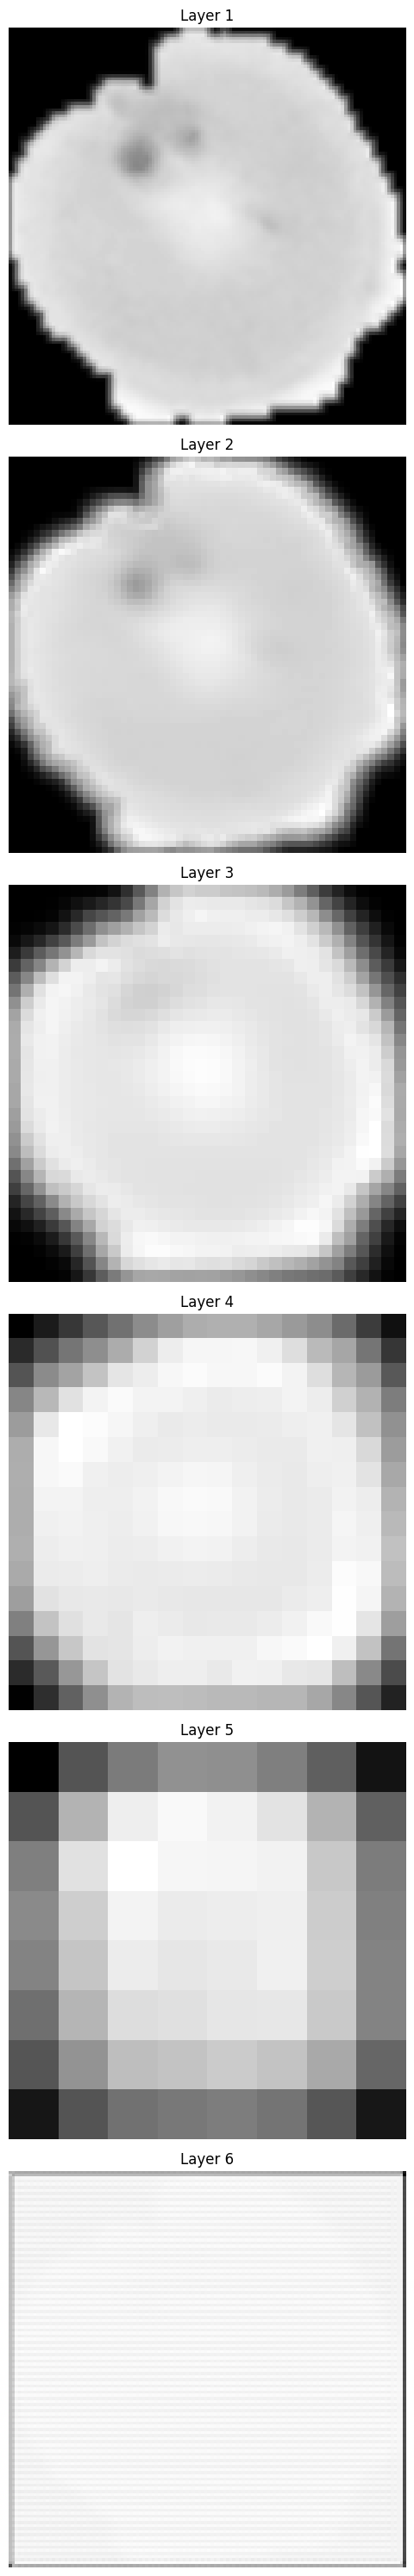

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_intermediate_outputs(model, images):
    model.eval()
    x = images
    x1 = model.inc(x)
    x2 = model.down1(x1)
    x3 = model.down2(x2)
    x4 = model.down3(x3)
    x5 = model.down4(x4)
    x = model.up1(x5, x4)
    x = model.up2(x, x3)
    x = model.up3(x, x2)
    x = model.up4(x, x1)
    
    intermediate_outputs = [x1, x2, x3, x4, x5, x]

    # Number of layers
    num_layers = len(intermediate_outputs)
    fig, axes = plt.subplots(num_layers, 1, figsize=(10, num_layers * 5))
    
    if num_layers == 1:
        axes = [axes]

    for i in range(num_layers):
        # Take the first image from the batch and the first channel of the output
        out = intermediate_outputs[i][0].detach().numpy()  # Shape [C, H, W]
        out = np.mean(out, axis=0)  # Convert to [H, W] by averaging over channels if needed
        out = (out - out.min()) / (out.max() - out.min())  # Normalize to [0, 1]

        axes[i].imshow(out, cmap='gray')
        axes[i].set_title(f'Layer {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
model = AttentionUNet(n_channels=3, n_classes=1)
model.eval()

# Load a batch of data
for images, masks in train_loader:

    with torch.no_grad():
        # Visualize intermediate outputs
        visualize_intermediate_outputs(model, images)
    break

In [10]:
# Function to display images and masks
def compare_segmented(images, outputs, masks):
    fig, axes = plt.subplots(len(images), 3, figsize=(10, len(images) * 5))
    
    if len(images) == 1:
        axes = [axes]
    
    for i in range(len(images)):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        output = outputs[i][0]  # Since n_classes=1, take the first channel
        output = (output - output.min()) / (output.max() - output.min())  # Normalize to [0, 1]
        mask = masks[i][0].cpu().numpy()

        axes[i][0].imshow(image)
        axes[i][0].set_title('Input Image')
        axes[i][0].axis('off')

        axes[i][1].imshow(output, cmap='gray')
        axes[i][1].set_title('Predicted Segmentation')
        axes[i][1].axis('off')

        axes[i][2].imshow(mask, cmap='gray')
        axes[i][2].set_title('Ground Truth Mask')
        axes[i][2].axis('off')

    plt.tight_layout()
    plt.show()

### Checking if model is functional before training

Output shape:  (4, 1, 128, 128)


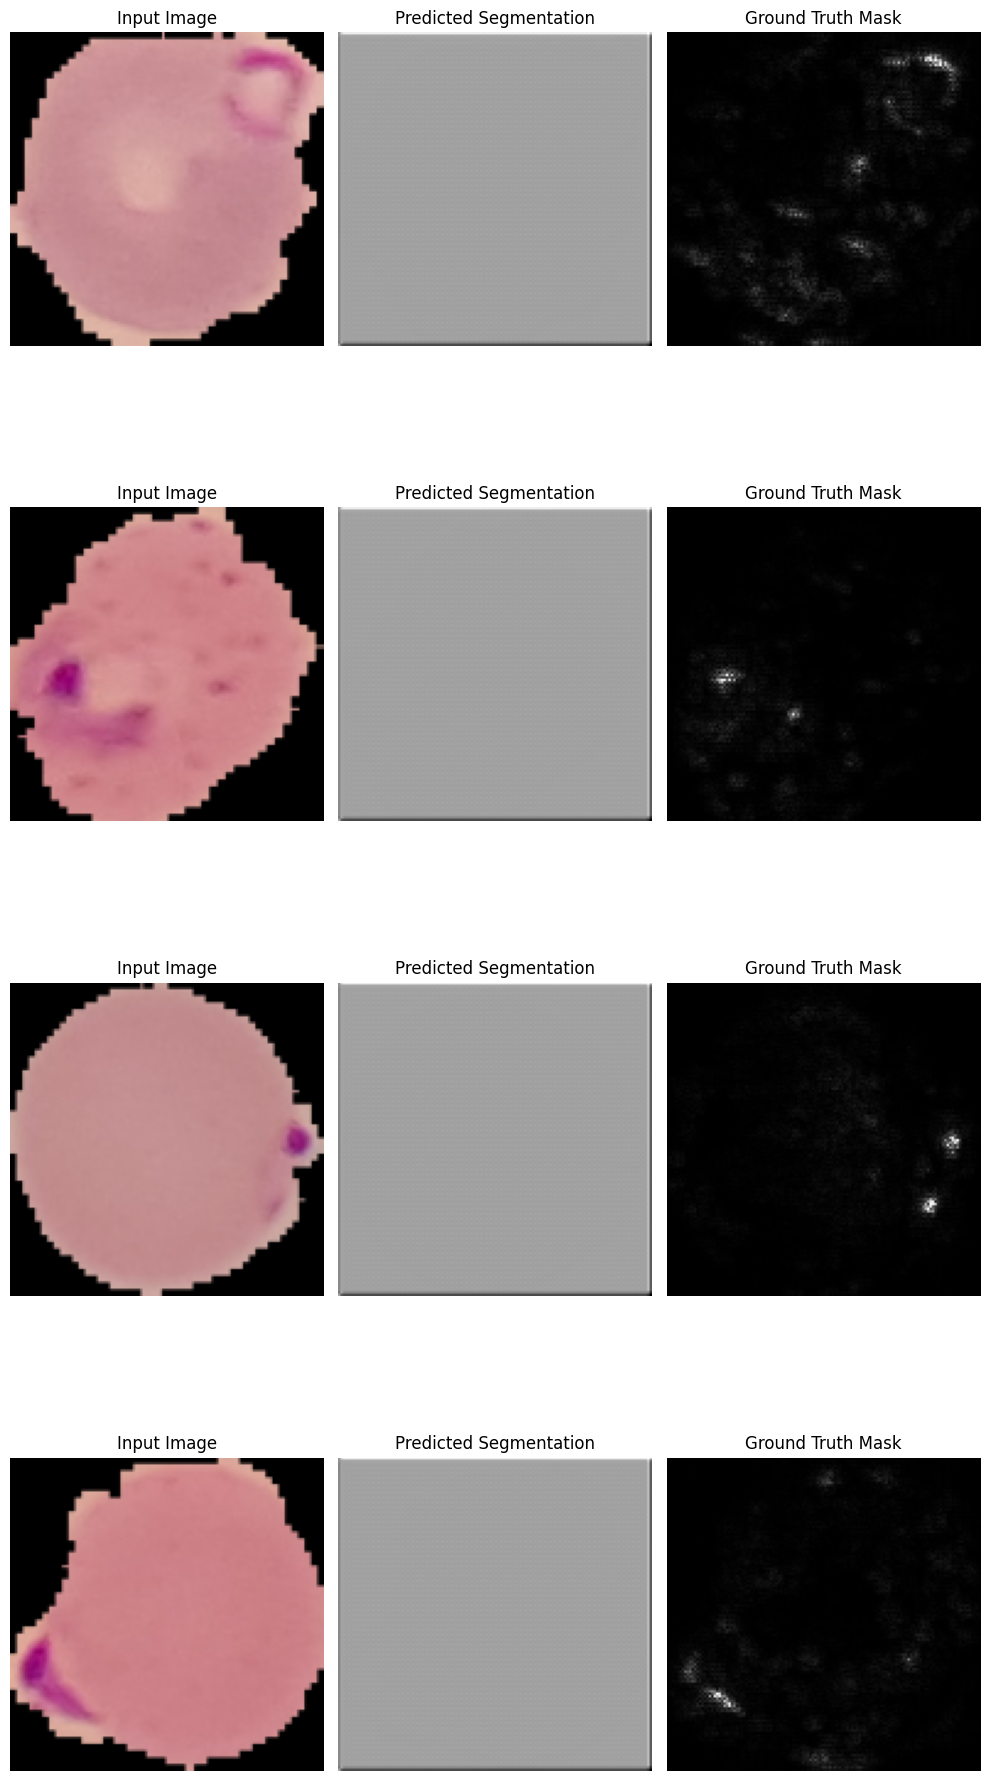

In [11]:
model = AttentionUNet(n_channels=3, n_classes=1) # Assuming binary segmentation
model.eval()

# Load a batch of data
for images, masks in train_loader:
    # Perform inference
    with torch.no_grad():
        outputs = model(images)
    
    # Convert outputs to numpy for visualization
    outputs = outputs.detach().numpy()

    print("Output shape: ", outputs.shape)
    
    # Visualize the results
    compare_segmented(images, outputs, masks)
    
    # Break after one batch for demonstration
    break

### Loss function and training loop

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from tqdm import tqdm

import torch
import torch.nn as nn

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        true_pos = (inputs * targets).sum()
        false_neg = ((1 - inputs) * targets).sum()
        false_pos = (inputs * (1 - targets)).sum()
        
        tversky_index = (true_pos + self.smooth) / (true_pos + self.alpha * false_neg + self.beta * false_pos + self.smooth)
        return 1 - tversky_index


def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=25, device='cuda', save_path='model.pth'):
    model = model.to(device)
    best_loss = float('inf')
    train_tversky_scores = []
    test_tversky_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_tversky_epoch = []

        for inputs, masks in tqdm(train_loader):
            inputs = inputs.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            train_tversky_epoch.append(tversky_coefficient(outputs, masks))

        epoch_loss = running_loss / len(train_loader.dataset)
        train_tversky_scores.append(sum(train_tversky_epoch) / len(train_tversky_epoch))
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Tversky: {train_tversky_scores[-1]:.4f}')

        # Evaluate on the test set
        model.eval()
        test_tversky_epoch = []
        with torch.no_grad():
            for inputs, masks in test_loader:
                inputs = inputs.to(device)
                masks = masks.to(device)

                outputs = model(inputs)
                test_tversky_epoch.append(tversky_coefficient(outputs, masks))

        test_tversky_scores.append(sum(test_tversky_epoch) / len(test_tversky_epoch))
        print(f'Test Tversky: {test_tversky_scores[-1]:.4f}')

        # Save the model if it has the best loss so far
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), save_path)
            print(f'Model weights saved at epoch {epoch} with loss {epoch_loss:.4f}')

    return model, train_tversky_scores, test_tversky_scores


In [13]:
def tversky_coefficient(inputs, targets, alpha=0.5, beta=0.5, smooth=1):
    inputs = torch.sigmoid(inputs)
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    
    true_pos = (inputs * targets).sum()
    false_neg = ((1 - inputs) * targets).sum()
    false_pos = (inputs * (1 - targets)).sum()
    
    tversky_index = (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
    return tversky_index.item()


### Training

In [14]:
model = AttentionUNet(n_channels=3, n_classes=1)  # Assuming binary segmentation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [15]:
num_epochs = 64
model, train_tversky_scores, test_tversky_scores = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs, device='cuda', save_path='unet_best_model.pth')

100%|██████████| 2756/2756 [06:07<00:00,  7.50it/s]


Epoch 0/63, Loss: 0.8708, Train Tversky: 0.1292
Test Tversky: 0.1374
Model weights saved at epoch 0 with loss 0.8708


100%|██████████| 2756/2756 [04:25<00:00, 10.38it/s]


Epoch 1/63, Loss: 0.8626, Train Tversky: 0.1374
Test Tversky: 0.1406
Model weights saved at epoch 1 with loss 0.8626


100%|██████████| 2756/2756 [04:25<00:00, 10.38it/s]


Epoch 2/63, Loss: 0.8605, Train Tversky: 0.1395
Test Tversky: 0.1411
Model weights saved at epoch 2 with loss 0.8605


100%|██████████| 2756/2756 [04:23<00:00, 10.45it/s]


Epoch 3/63, Loss: 0.8586, Train Tversky: 0.1414
Test Tversky: 0.1443
Model weights saved at epoch 3 with loss 0.8586


100%|██████████| 2756/2756 [04:25<00:00, 10.37it/s]


Epoch 4/63, Loss: 0.8568, Train Tversky: 0.1432
Test Tversky: 0.1445
Model weights saved at epoch 4 with loss 0.8568


100%|██████████| 2756/2756 [04:24<00:00, 10.41it/s]


Epoch 5/63, Loss: 0.8556, Train Tversky: 0.1444
Test Tversky: 0.1462
Model weights saved at epoch 5 with loss 0.8556


100%|██████████| 2756/2756 [04:23<00:00, 10.44it/s]


Epoch 6/63, Loss: 0.8547, Train Tversky: 0.1453
Test Tversky: 0.1465
Model weights saved at epoch 6 with loss 0.8547


100%|██████████| 2756/2756 [04:24<00:00, 10.42it/s]


Epoch 7/63, Loss: 0.8537, Train Tversky: 0.1463
Test Tversky: 0.1474
Model weights saved at epoch 7 with loss 0.8537


100%|██████████| 2756/2756 [04:24<00:00, 10.41it/s]


Epoch 8/63, Loss: 0.8529, Train Tversky: 0.1471
Test Tversky: 0.1463
Model weights saved at epoch 8 with loss 0.8529


100%|██████████| 2756/2756 [04:24<00:00, 10.42it/s]


Epoch 9/63, Loss: 0.8520, Train Tversky: 0.1480
Test Tversky: 0.1458
Model weights saved at epoch 9 with loss 0.8520


100%|██████████| 2756/2756 [04:23<00:00, 10.46it/s]


Epoch 10/63, Loss: 0.8515, Train Tversky: 0.1485
Test Tversky: 0.1500
Model weights saved at epoch 10 with loss 0.8515


100%|██████████| 2756/2756 [04:23<00:00, 10.47it/s]


Epoch 11/63, Loss: 0.8511, Train Tversky: 0.1489
Test Tversky: 0.1500
Model weights saved at epoch 11 with loss 0.8511


100%|██████████| 2756/2756 [04:23<00:00, 10.46it/s]


Epoch 12/63, Loss: 0.8505, Train Tversky: 0.1495
Test Tversky: 0.1498
Model weights saved at epoch 12 with loss 0.8505


100%|██████████| 2756/2756 [04:23<00:00, 10.45it/s]


Epoch 13/63, Loss: 0.8498, Train Tversky: 0.1502
Test Tversky: 0.1498
Model weights saved at epoch 13 with loss 0.8498


100%|██████████| 2756/2756 [04:23<00:00, 10.45it/s]


Epoch 14/63, Loss: 0.8496, Train Tversky: 0.1504
Test Tversky: 0.1495
Model weights saved at epoch 14 with loss 0.8496


100%|██████████| 2756/2756 [04:23<00:00, 10.46it/s]


Epoch 15/63, Loss: 0.8491, Train Tversky: 0.1509
Test Tversky: 0.1515
Model weights saved at epoch 15 with loss 0.8491


100%|██████████| 2756/2756 [04:23<00:00, 10.47it/s]


Epoch 16/63, Loss: 0.8488, Train Tversky: 0.1512
Test Tversky: 0.1511
Model weights saved at epoch 16 with loss 0.8488


100%|██████████| 2756/2756 [04:25<00:00, 10.40it/s]


Epoch 17/63, Loss: 0.8482, Train Tversky: 0.1518
Test Tversky: 0.1509
Model weights saved at epoch 17 with loss 0.8482


100%|██████████| 2756/2756 [04:23<00:00, 10.45it/s]


Epoch 18/63, Loss: 0.8480, Train Tversky: 0.1520
Test Tversky: 0.1515
Model weights saved at epoch 18 with loss 0.8480


100%|██████████| 2756/2756 [04:23<00:00, 10.47it/s]


Epoch 19/63, Loss: 0.8476, Train Tversky: 0.1524
Test Tversky: 0.1509
Model weights saved at epoch 19 with loss 0.8476


100%|██████████| 2756/2756 [04:23<00:00, 10.47it/s]


Epoch 20/63, Loss: 0.8473, Train Tversky: 0.1527
Test Tversky: 0.1505
Model weights saved at epoch 20 with loss 0.8473


100%|██████████| 2756/2756 [04:23<00:00, 10.44it/s]


Epoch 21/63, Loss: 0.8469, Train Tversky: 0.1531
Test Tversky: 0.1510
Model weights saved at epoch 21 with loss 0.8469


100%|██████████| 2756/2756 [04:24<00:00, 10.41it/s]


Epoch 22/63, Loss: 0.8467, Train Tversky: 0.1533
Test Tversky: 0.1523
Model weights saved at epoch 22 with loss 0.8467


100%|██████████| 2756/2756 [04:23<00:00, 10.45it/s]


Epoch 23/63, Loss: 0.8463, Train Tversky: 0.1537
Test Tversky: 0.1525
Model weights saved at epoch 23 with loss 0.8463


100%|██████████| 2756/2756 [04:23<00:00, 10.44it/s]


Epoch 24/63, Loss: 0.8460, Train Tversky: 0.1540
Test Tversky: 0.1519
Model weights saved at epoch 24 with loss 0.8460


100%|██████████| 2756/2756 [04:24<00:00, 10.43it/s]


Epoch 25/63, Loss: 0.8456, Train Tversky: 0.1544
Test Tversky: 0.1531
Model weights saved at epoch 25 with loss 0.8456


100%|██████████| 2756/2756 [04:24<00:00, 10.43it/s]


Epoch 26/63, Loss: 0.8453, Train Tversky: 0.1547
Test Tversky: 0.1524
Model weights saved at epoch 26 with loss 0.8453


100%|██████████| 2756/2756 [04:25<00:00, 10.36it/s]


Epoch 27/63, Loss: 0.8450, Train Tversky: 0.1550
Test Tversky: 0.1520
Model weights saved at epoch 27 with loss 0.8450


100%|██████████| 2756/2756 [04:23<00:00, 10.47it/s]


Epoch 28/63, Loss: 0.8445, Train Tversky: 0.1555
Test Tversky: 0.1516
Model weights saved at epoch 28 with loss 0.8445


100%|██████████| 2756/2756 [04:23<00:00, 10.45it/s]


Epoch 29/63, Loss: 0.8444, Train Tversky: 0.1556
Test Tversky: 0.1518
Model weights saved at epoch 29 with loss 0.8444


100%|██████████| 2756/2756 [04:23<00:00, 10.45it/s]


Epoch 30/63, Loss: 0.8441, Train Tversky: 0.1559
Test Tversky: 0.1526
Model weights saved at epoch 30 with loss 0.8441


100%|██████████| 2756/2756 [04:23<00:00, 10.47it/s]


Epoch 31/63, Loss: 0.8439, Train Tversky: 0.1561
Test Tversky: 0.1522
Model weights saved at epoch 31 with loss 0.8439


100%|██████████| 2756/2756 [04:23<00:00, 10.46it/s]


Epoch 32/63, Loss: 0.8434, Train Tversky: 0.1566
Test Tversky: 0.1509
Model weights saved at epoch 32 with loss 0.8434


100%|██████████| 2756/2756 [04:23<00:00, 10.45it/s]


Epoch 33/63, Loss: 0.8431, Train Tversky: 0.1569
Test Tversky: 0.1532
Model weights saved at epoch 33 with loss 0.8431


100%|██████████| 2756/2756 [04:23<00:00, 10.45it/s]


Epoch 34/63, Loss: 0.8427, Train Tversky: 0.1573
Test Tversky: 0.1514
Model weights saved at epoch 34 with loss 0.8427


100%|██████████| 2756/2756 [04:23<00:00, 10.46it/s]


Epoch 35/63, Loss: 0.8424, Train Tversky: 0.1576
Test Tversky: 0.1532
Model weights saved at epoch 35 with loss 0.8424


100%|██████████| 2756/2756 [04:23<00:00, 10.47it/s]


Epoch 36/63, Loss: 0.8421, Train Tversky: 0.1579
Test Tversky: 0.1530
Model weights saved at epoch 36 with loss 0.8421


100%|██████████| 2756/2756 [04:23<00:00, 10.45it/s]


Epoch 37/63, Loss: 0.8416, Train Tversky: 0.1584
Test Tversky: 0.1522
Model weights saved at epoch 37 with loss 0.8416


100%|██████████| 2756/2756 [04:24<00:00, 10.42it/s]


Epoch 38/63, Loss: 0.8414, Train Tversky: 0.1586
Test Tversky: 0.1531
Model weights saved at epoch 38 with loss 0.8414


100%|██████████| 2756/2756 [04:23<00:00, 10.45it/s]


Epoch 39/63, Loss: 0.8413, Train Tversky: 0.1587
Test Tversky: 0.1531
Model weights saved at epoch 39 with loss 0.8413


100%|██████████| 2756/2756 [04:22<00:00, 10.48it/s]


Epoch 40/63, Loss: 0.8410, Train Tversky: 0.1590
Test Tversky: 0.1511
Model weights saved at epoch 40 with loss 0.8410


100%|██████████| 2756/2756 [04:22<00:00, 10.49it/s]


Epoch 41/63, Loss: 0.8405, Train Tversky: 0.1595
Test Tversky: 0.1529
Model weights saved at epoch 41 with loss 0.8405


100%|██████████| 2756/2756 [04:24<00:00, 10.43it/s]


Epoch 42/63, Loss: 0.8402, Train Tversky: 0.1598
Test Tversky: 0.1520
Model weights saved at epoch 42 with loss 0.8402


100%|██████████| 2756/2756 [04:23<00:00, 10.45it/s]


Epoch 43/63, Loss: 0.8400, Train Tversky: 0.1600
Test Tversky: 0.1530
Model weights saved at epoch 43 with loss 0.8400


100%|██████████| 2756/2756 [04:23<00:00, 10.47it/s]


Epoch 44/63, Loss: 0.8397, Train Tversky: 0.1603
Test Tversky: 0.1523
Model weights saved at epoch 44 with loss 0.8397


100%|██████████| 2756/2756 [04:23<00:00, 10.46it/s]


Epoch 45/63, Loss: 0.8394, Train Tversky: 0.1606
Test Tversky: 0.1533
Model weights saved at epoch 45 with loss 0.8394


100%|██████████| 2756/2756 [04:24<00:00, 10.43it/s]


Epoch 46/63, Loss: 0.8392, Train Tversky: 0.1608
Test Tversky: 0.1527
Model weights saved at epoch 46 with loss 0.8392


100%|██████████| 2756/2756 [04:24<00:00, 10.40it/s]


Epoch 47/63, Loss: 0.8389, Train Tversky: 0.1611
Test Tversky: 0.1511
Model weights saved at epoch 47 with loss 0.8389


100%|██████████| 2756/2756 [04:24<00:00, 10.41it/s]


Epoch 48/63, Loss: 0.8384, Train Tversky: 0.1616
Test Tversky: 0.1518
Model weights saved at epoch 48 with loss 0.8384


100%|██████████| 2756/2756 [04:24<00:00, 10.40it/s]


Epoch 49/63, Loss: 0.8381, Train Tversky: 0.1619
Test Tversky: 0.1531
Model weights saved at epoch 49 with loss 0.8381


100%|██████████| 2756/2756 [04:24<00:00, 10.42it/s]


Epoch 50/63, Loss: 0.8380, Train Tversky: 0.1620
Test Tversky: 0.1528
Model weights saved at epoch 50 with loss 0.8380


100%|██████████| 2756/2756 [04:24<00:00, 10.41it/s]


Epoch 51/63, Loss: 0.8376, Train Tversky: 0.1624
Test Tversky: 0.1520
Model weights saved at epoch 51 with loss 0.8376


100%|██████████| 2756/2756 [04:24<00:00, 10.43it/s]


Epoch 52/63, Loss: 0.8373, Train Tversky: 0.1627
Test Tversky: 0.1532
Model weights saved at epoch 52 with loss 0.8373


100%|██████████| 2756/2756 [04:24<00:00, 10.43it/s]


Epoch 53/63, Loss: 0.8372, Train Tversky: 0.1628
Test Tversky: 0.1526
Model weights saved at epoch 53 with loss 0.8372


100%|██████████| 2756/2756 [04:23<00:00, 10.44it/s]


Epoch 54/63, Loss: 0.8369, Train Tversky: 0.1631
Test Tversky: 0.1528
Model weights saved at epoch 54 with loss 0.8369


100%|██████████| 2756/2756 [04:24<00:00, 10.41it/s]


Epoch 55/63, Loss: 0.8367, Train Tversky: 0.1633
Test Tversky: 0.1529
Model weights saved at epoch 55 with loss 0.8367


100%|██████████| 2756/2756 [04:25<00:00, 10.40it/s]


Epoch 56/63, Loss: 0.8362, Train Tversky: 0.1638
Test Tversky: 0.1515
Model weights saved at epoch 56 with loss 0.8362


100%|██████████| 2756/2756 [04:23<00:00, 10.44it/s]


Epoch 57/63, Loss: 0.8362, Train Tversky: 0.1638
Test Tversky: 0.1526
Model weights saved at epoch 57 with loss 0.8362


100%|██████████| 2756/2756 [04:23<00:00, 10.46it/s]


Epoch 58/63, Loss: 0.8360, Train Tversky: 0.1640
Test Tversky: 0.1534
Model weights saved at epoch 58 with loss 0.8360


100%|██████████| 2756/2756 [04:24<00:00, 10.42it/s]


Epoch 59/63, Loss: 0.8360, Train Tversky: 0.1640
Test Tversky: 0.1534
Model weights saved at epoch 59 with loss 0.8360


100%|██████████| 2756/2756 [04:23<00:00, 10.45it/s]


Epoch 60/63, Loss: 0.8355, Train Tversky: 0.1645
Test Tversky: 0.1529
Model weights saved at epoch 60 with loss 0.8355


100%|██████████| 2756/2756 [04:23<00:00, 10.46it/s]


Epoch 61/63, Loss: 0.8355, Train Tversky: 0.1645
Test Tversky: 0.1529


100%|██████████| 2756/2756 [04:23<00:00, 10.47it/s]


Epoch 62/63, Loss: 0.8352, Train Tversky: 0.1648
Test Tversky: 0.1531
Model weights saved at epoch 62 with loss 0.8352


100%|██████████| 2756/2756 [04:24<00:00, 10.42it/s]


Epoch 63/63, Loss: 0.8349, Train Tversky: 0.1651
Test Tversky: 0.1533
Model weights saved at epoch 63 with loss 0.8349


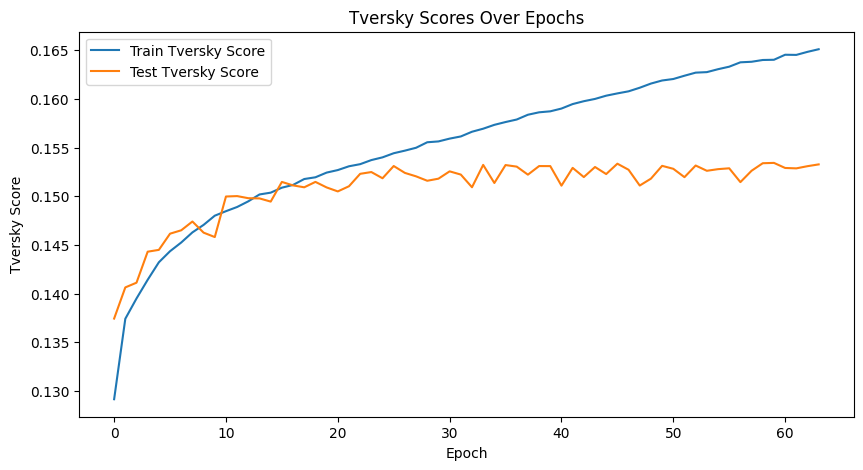

In [16]:
# Plotting the Dice scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_tversky_scores, label='Train Tversky Score')
plt.plot(test_tversky_scores, label='Test Tversky Score')
plt.xlabel('Epoch')
plt.ylabel('Tversky Score')
plt.legend()
plt.title('Tversky Scores Over Epochs')
plt.show()

### Visualizing segmented train and test images vs ground truth

Output shape:  (4, 1, 128, 128)


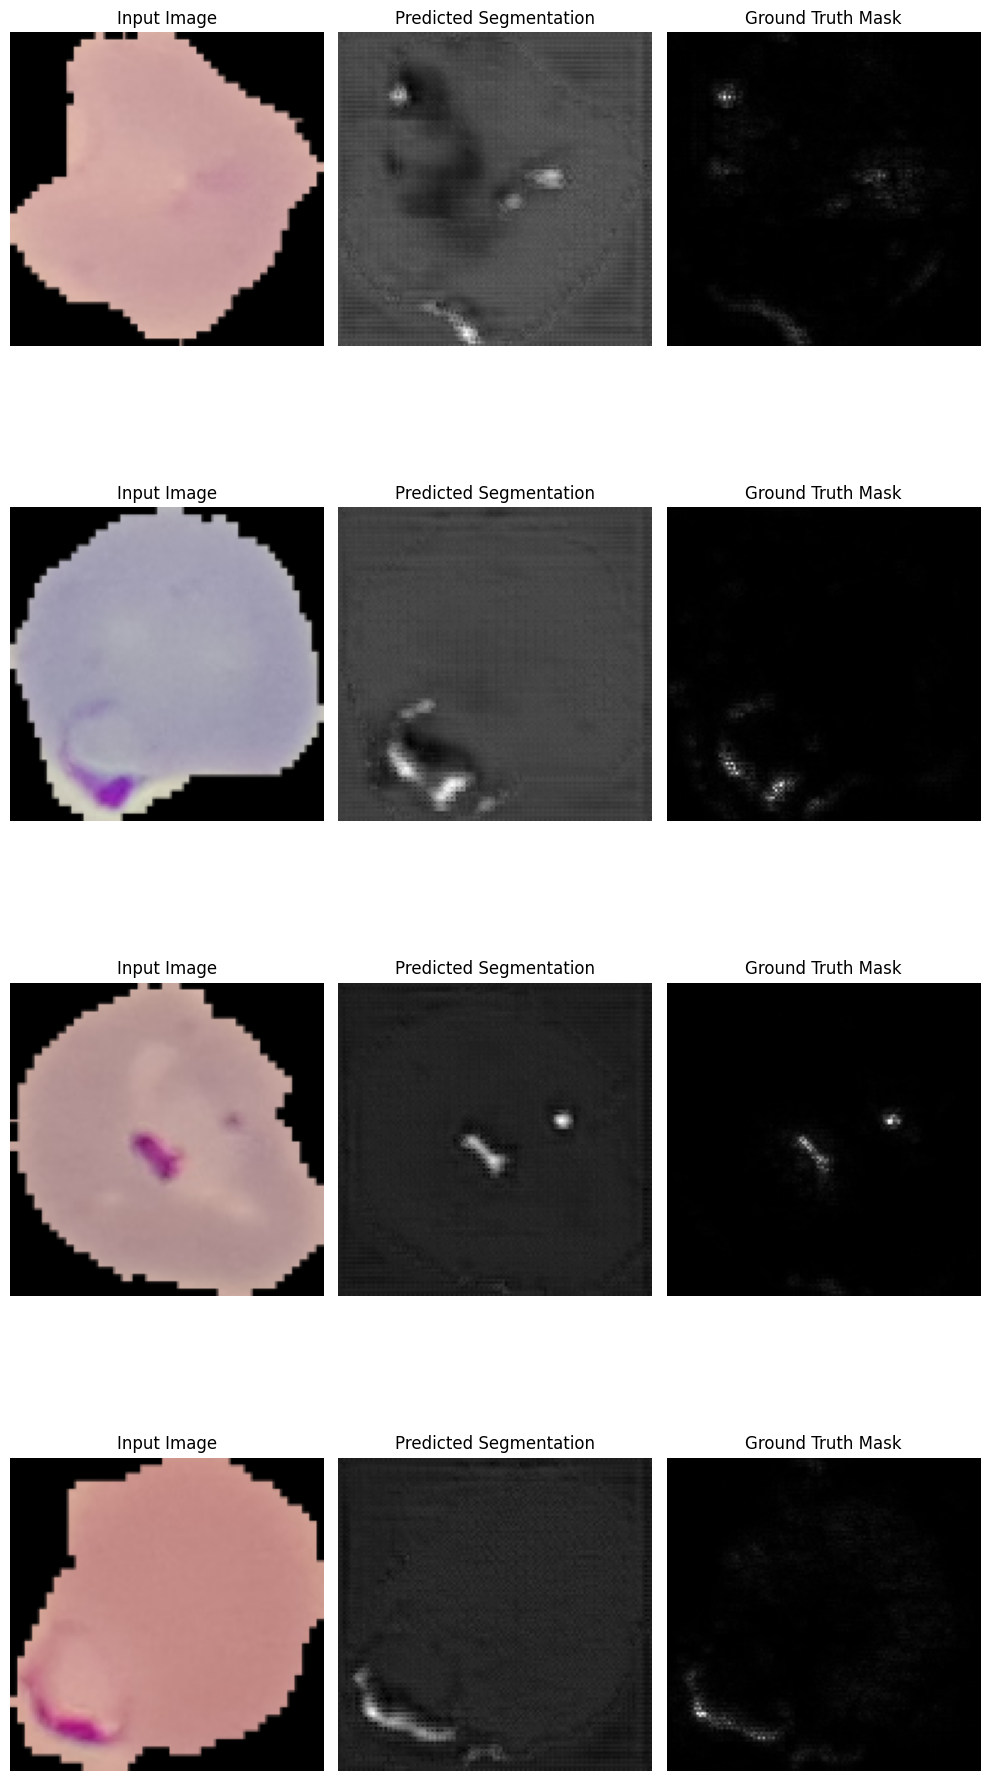

In [17]:
#train images
for images, masks in train_loader:
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ",outputs.shape)
    compare_segmented(images, outputs, masks)
    break

Output shape:  (4, 1, 128, 128)


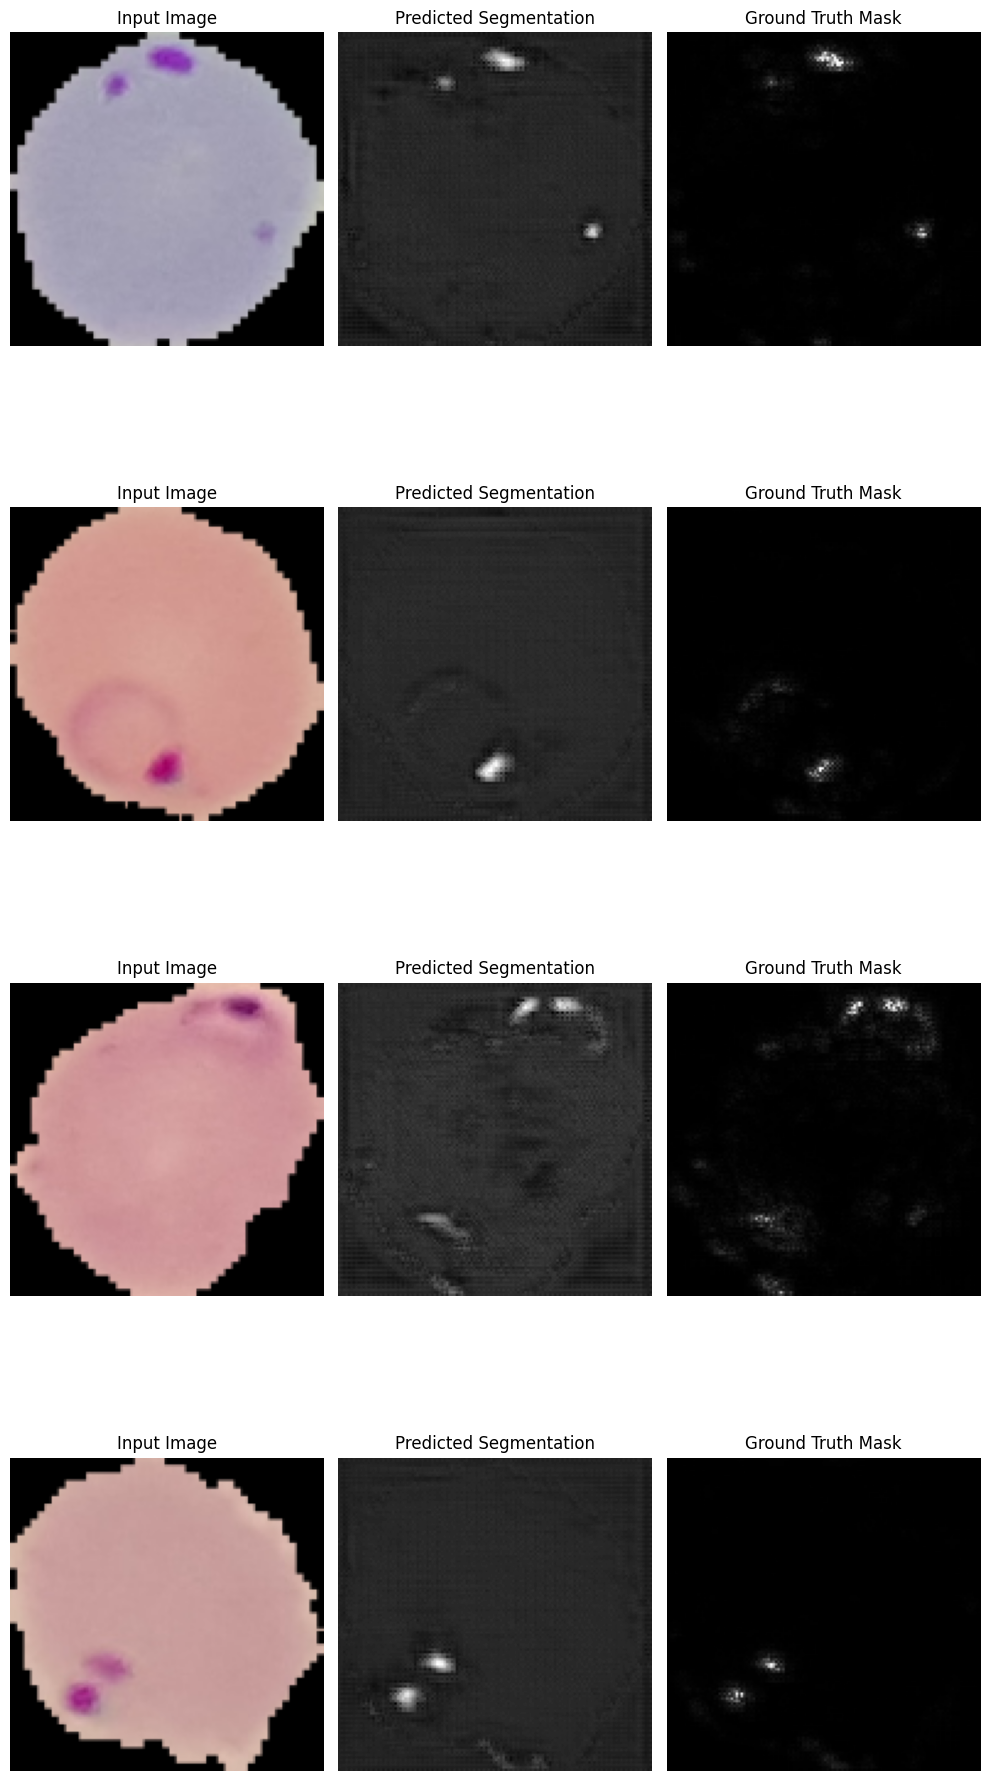

In [18]:
#test images
for images, masks in test_loader:
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ",outputs.shape)
    compare_segmented(images, outputs, masks)
    break

Output shape:  (4, 1, 128, 128)
Computational Time: 0.1141 seconds
Accuracy: 0.9718780517578125
Precision: 0.9715639810426541
Recall: 0.31072375899962107
F1 Score: 0.4708584553545794
Sensitivity: 0.31072375899962107
Specificity: 0.999618423772199
Error Rate: 0.0281219482421875
Confusion Matrix: [[62873    24]
 [ 1819   820]]


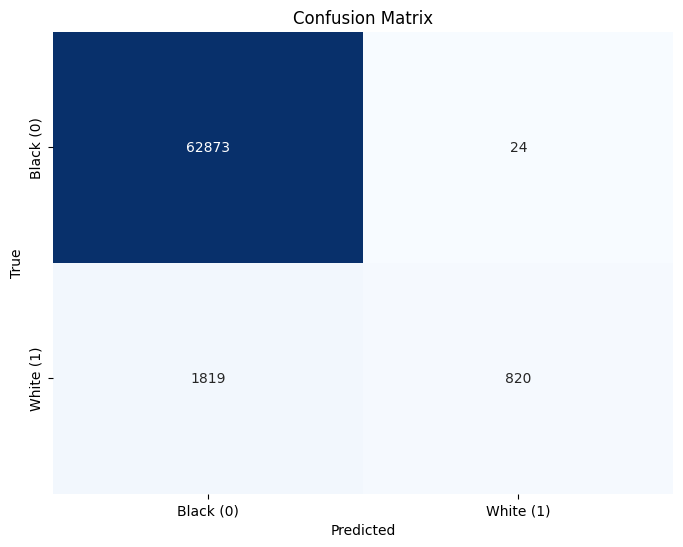

In [19]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_segmentation(outputs, masks):
    # Binarize the predictions and masks
    preds = (outputs > 0.05).astype(np.uint8)  # Assuming a threshold of 0.5
    true_masks = (masks > 0.05).astype(np.uint8)

    # Flatten the arrays for metrics calculation
    preds_flat = preds.flatten()
    true_masks_flat = true_masks.flatten()

    # Calculate metrics
    accuracy = accuracy_score(true_masks_flat, preds_flat)
    precision = precision_score(true_masks_flat, preds_flat)
    recall = recall_score(true_masks_flat, preds_flat)
    f1 = f1_score(true_masks_flat, preds_flat)

    # Calculate confusion matrix
    cm = confusion_matrix(true_masks_flat, preds_flat)

    # Sensitivity and specificity
    tp = cm[1, 1]  # True positives
    tn = cm[0, 0]  # True negatives
    fp = cm[0, 1]  # False positives
    fn = cm[1, 0]  # False negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Error rate
    error_rate = (fp + fn) / (tp + tn + fp + fn)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Error Rate": error_rate,
        "Confusion Matrix": cm
    }

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Black (0)', 'White (1)'], yticklabels=['Black (0)', 'White (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Training Loop with Evaluation
for images, masks in train_loader:
    start_time = time.time()  # Start timer
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ", outputs.shape)
    
    # Call the evaluation function
    metrics = evaluate_segmentation(outputs, masks.cpu().numpy())
    
    # Compute computational time
    computation_time = time.time() - start_time
    print("Computational Time: {:.4f} seconds".format(computation_time))
    
    # Print metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics["Confusion Matrix"])
    
    break  # Remove this break to evaluate on the full dataset

Output shape:  (4, 1, 128, 128)
Computational Time: 0.1116 seconds
Accuracy: 0.996978759765625
Precision: 0.6947368421052632
Recall: 0.8616187989556136
F1 Score: 0.7692307692307692
Sensitivity: 0.8616187989556136
Specificity: 0.997774469326048
Error Rate: 0.003021240234375
Confusion Matrix: [[65008   145]
 [   53   330]]


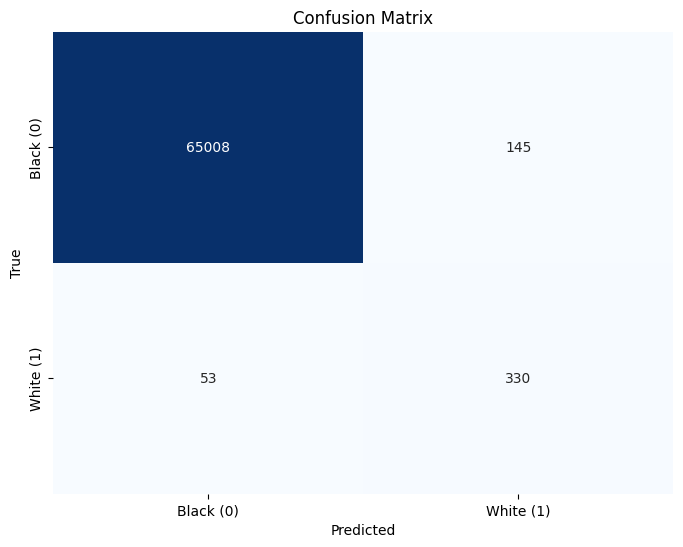

In [20]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_segmentation(outputs, masks):
    # Binarize the predictions and masks
    preds = (outputs > 0.1).astype(np.uint8)  # Assuming a threshold of 0.5
    true_masks = (masks > 0.1).astype(np.uint8)

    # Flatten the arrays for metrics calculation
    preds_flat = preds.flatten()
    true_masks_flat = true_masks.flatten()

    # Calculate metrics
    accuracy = accuracy_score(true_masks_flat, preds_flat)
    precision = precision_score(true_masks_flat, preds_flat)
    recall = recall_score(true_masks_flat, preds_flat)
    f1 = f1_score(true_masks_flat, preds_flat)

    # Calculate confusion matrix
    cm = confusion_matrix(true_masks_flat, preds_flat)

    # Sensitivity and specificity
    tp = cm[1, 1]  # True positives
    tn = cm[0, 0]  # True negatives
    fp = cm[0, 1]  # False positives
    fn = cm[1, 0]  # False negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Error rate
    error_rate = (fp + fn) / (tp + tn + fp + fn)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Error Rate": error_rate,
        "Confusion Matrix": cm
    }

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Black (0)', 'White (1)'], yticklabels=['Black (0)', 'White (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Training Loop with Evaluation
for images, masks in train_loader:
    start_time = time.time()  # Start timer
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ", outputs.shape)
    
    # Call the evaluation function
    metrics = evaluate_segmentation(outputs, masks.cpu().numpy())
    
    # Compute computational time
    computation_time = time.time() - start_time
    print("Computational Time: {:.4f} seconds".format(computation_time))
    
    # Print metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics["Confusion Matrix"])
    
    break  # Remove this break to evaluate on the full dataset

Output shape:  (4, 1, 128, 128)
Computational Time: 0.1157 seconds
Accuracy: 0.976409912109375
Precision: 0.05327617881200245
Recall: 1.0
F1 Score: 0.10116279069767442
Sensitivity: 1.0
Specificity: 0.9763785542941833
Error Rate: 0.023590087890625
Confusion Matrix: [[63903  1546]
 [    0    87]]


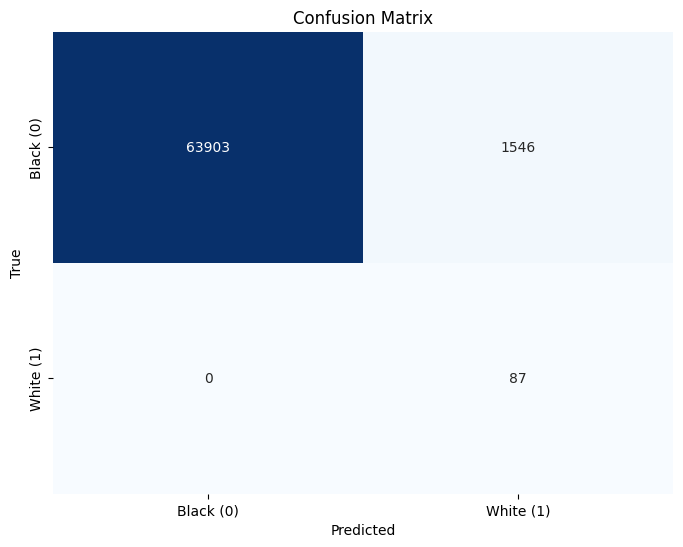

In [21]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_segmentation(outputs, masks):
    # Binarize the predictions and masks
    preds = (outputs > 0.5).astype(np.uint8)  # Assuming a threshold of 0.5
    true_masks = (masks > 0.5).astype(np.uint8)

    # Flatten the arrays for metrics calculation
    preds_flat = preds.flatten()
    true_masks_flat = true_masks.flatten()

    # Calculate metrics
    accuracy = accuracy_score(true_masks_flat, preds_flat)
    precision = precision_score(true_masks_flat, preds_flat)
    recall = recall_score(true_masks_flat, preds_flat)
    f1 = f1_score(true_masks_flat, preds_flat)

    # Calculate confusion matrix
    cm = confusion_matrix(true_masks_flat, preds_flat)

    # Sensitivity and specificity
    tp = cm[1, 1]  # True positives
    tn = cm[0, 0]  # True negatives
    fp = cm[0, 1]  # False positives
    fn = cm[1, 0]  # False negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Error rate
    error_rate = (fp + fn) / (tp + tn + fp + fn)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Error Rate": error_rate,
        "Confusion Matrix": cm
    }

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Black (0)', 'White (1)'], yticklabels=['Black (0)', 'White (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Training Loop with Evaluation
for images, masks in train_loader:
    start_time = time.time()  # Start timer
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ", outputs.shape)
    
    # Call the evaluation function
    metrics = evaluate_segmentation(outputs, masks.cpu().numpy())
    
    # Compute computational time
    computation_time = time.time() - start_time
    print("Computational Time: {:.4f} seconds".format(computation_time))
    
    # Print metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics["Confusion Matrix"])
    
    break  # Remove this break to evaluate on the full dataset

Output shape:  (4, 1, 128, 128)
Computational Time: 0.1111 seconds
Accuracy: 0.9878692626953125
Precision: 0.10674157303370786
Recall: 1.0
F1 Score: 0.19289340101522842
Sensitivity: 1.0
Specificity: 0.98785165263367
Error Rate: 0.0121307373046875
Confusion Matrix: [[64646   795]
 [    0    95]]


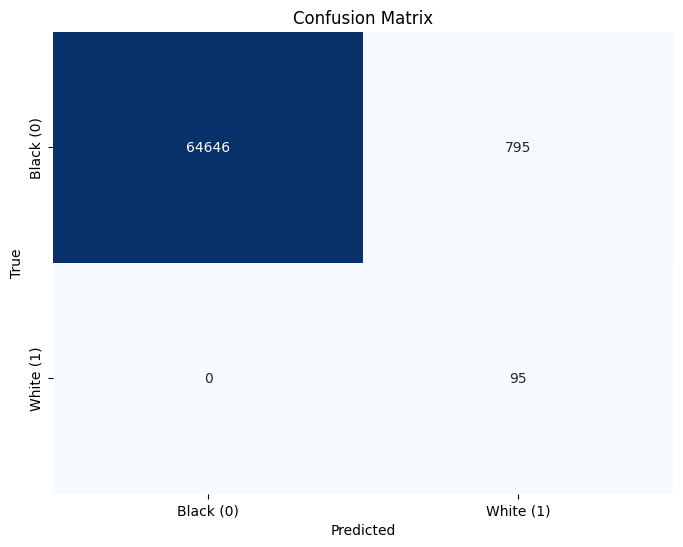

In [22]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_segmentation(outputs, masks):
    # Binarize the predictions and masks
    preds = (outputs > 0.5).astype(np.uint8)  # Assuming a threshold of 0.5
    true_masks = (masks > 0.5).astype(np.uint8)

    # Flatten the arrays for metrics calculation
    preds_flat = preds.flatten()
    true_masks_flat = true_masks.flatten()

    # Calculate metrics
    accuracy = accuracy_score(true_masks_flat, preds_flat)
    precision = precision_score(true_masks_flat, preds_flat)
    recall = recall_score(true_masks_flat, preds_flat)
    f1 = f1_score(true_masks_flat, preds_flat)

    # Calculate confusion matrix
    cm = confusion_matrix(true_masks_flat, preds_flat)

    # Sensitivity and specificity
    tp = cm[1, 1]  # True positives
    tn = cm[0, 0]  # True negatives
    fp = cm[0, 1]  # False positives
    fn = cm[1, 0]  # False negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Error rate
    error_rate = (fp + fn) / (tp + tn + fp + fn)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Error Rate": error_rate,
        "Confusion Matrix": cm
    }

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Black (0)', 'White (1)'], yticklabels=['Black (0)', 'White (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Training Loop with Evaluation
for images, masks in test_loader:
    start_time = time.time()  # Start timer
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ", outputs.shape)
    
    # Call the evaluation function
    metrics = evaluate_segmentation(outputs, masks.cpu().numpy())
    
    # Compute computational time
    computation_time = time.time() - start_time
    print("Computational Time: {:.4f} seconds".format(computation_time))
    
    # Print metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics["Confusion Matrix"])
    
    break  # Remove this break to evaluate on the full dataset

Output shape:  (4, 1, 128, 128)
Computational Time: 0.1145 seconds
Accuracy: 0.9904327392578125
Precision: 0.7670772676371781
Recall: 0.6204710144927537
F1 Score: 0.6860290435653481
Sensitivity: 0.6204710144927537
Specificity: 0.9967717904147008
Error Rate: 0.0095672607421875
Confusion Matrix: [[64224   208]
 [  419   685]]


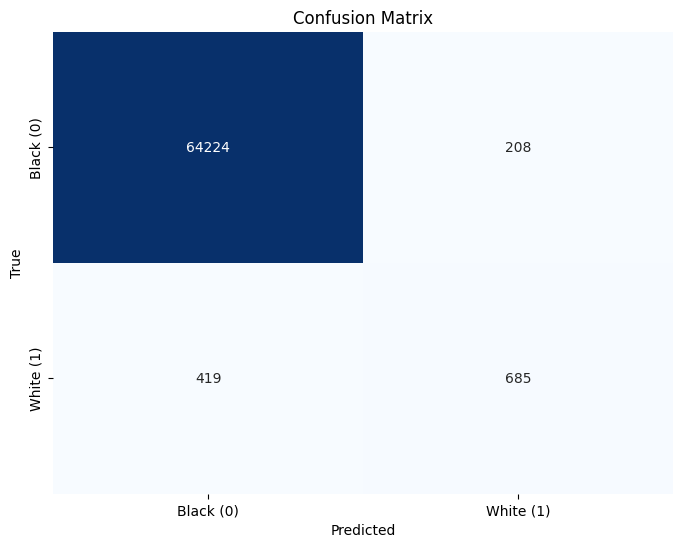

In [23]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_segmentation(outputs, masks):
    # Binarize the predictions and masks
    preds = (outputs > 0.1).astype(np.uint8)  # Assuming a threshold of 0.5
    true_masks = (masks > 0.1).astype(np.uint8)

    # Flatten the arrays for metrics calculation
    preds_flat = preds.flatten()
    true_masks_flat = true_masks.flatten()

    # Calculate metrics
    accuracy = accuracy_score(true_masks_flat, preds_flat)
    precision = precision_score(true_masks_flat, preds_flat)
    recall = recall_score(true_masks_flat, preds_flat)
    f1 = f1_score(true_masks_flat, preds_flat)

    # Calculate confusion matrix
    cm = confusion_matrix(true_masks_flat, preds_flat)

    # Sensitivity and specificity
    tp = cm[1, 1]  # True positives
    tn = cm[0, 0]  # True negatives
    fp = cm[0, 1]  # False positives
    fn = cm[1, 0]  # False negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Error rate
    error_rate = (fp + fn) / (tp + tn + fp + fn)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Error Rate": error_rate,
        "Confusion Matrix": cm
    }

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Black (0)', 'White (1)'], yticklabels=['Black (0)', 'White (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Training Loop with Evaluation
for images, masks in test_loader:
    start_time = time.time()  # Start timer
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ", outputs.shape)
    
    # Call the evaluation function
    metrics = evaluate_segmentation(outputs, masks.cpu().numpy())
    
    # Compute computational time
    computation_time = time.time() - start_time
    print("Computational Time: {:.4f} seconds".format(computation_time))
    
    # Print metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics["Confusion Matrix"])
    
    break  # Remove this break to evaluate on the full dataset

Output shape:  (4, 1, 128, 128)
Computational Time: 0.1139 seconds
Accuracy: 0.9904327392578125
Precision: 0.7670772676371781
Recall: 0.6204710144927537
F1 Score: 0.6860290435653481
Sensitivity: 0.6204710144927537
Specificity: 0.9967717904147008
Error Rate: 0.0095672607421875
Confusion Matrix: [[64224   208]
 [  419   685]]


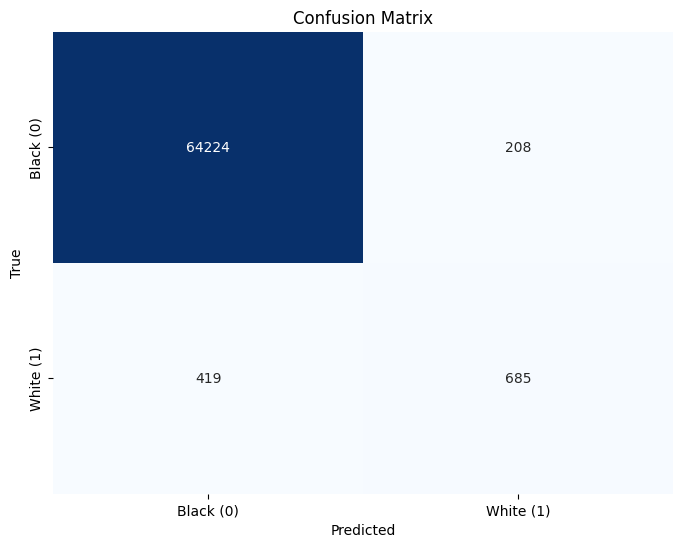

In [24]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_segmentation(outputs, masks):
    # Binarize the predictions and masks
    preds = (outputs > 0.1).astype(np.uint8)  # Assuming a threshold of 0.5
    true_masks = (masks > 0.1).astype(np.uint8)

    # Flatten the arrays for metrics calculation
    preds_flat = preds.flatten()
    true_masks_flat = true_masks.flatten()

    # Calculate metrics
    accuracy = accuracy_score(true_masks_flat, preds_flat)
    precision = precision_score(true_masks_flat, preds_flat)
    recall = recall_score(true_masks_flat, preds_flat)
    f1 = f1_score(true_masks_flat, preds_flat)

    # Calculate confusion matrix
    cm = confusion_matrix(true_masks_flat, preds_flat)

    # Sensitivity and specificity
    tp = cm[1, 1]  # True positives
    tn = cm[0, 0]  # True negatives
    fp = cm[0, 1]  # False positives
    fn = cm[1, 0]  # False negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Error rate
    error_rate = (fp + fn) / (tp + tn + fp + fn)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Error Rate": error_rate,
        "Confusion Matrix": cm
    }

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Black (0)', 'White (1)'], yticklabels=['Black (0)', 'White (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Training Loop with Evaluation
for images, masks in test_loader:
    start_time = time.time()  # Start timer
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ", outputs.shape)
    
    # Call the evaluation function
    metrics = evaluate_segmentation(outputs, masks.cpu().numpy())
    
    # Compute computational time
    computation_time = time.time() - start_time
    print("Computational Time: {:.4f} seconds".format(computation_time))
    
    # Print metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics["Confusion Matrix"])
    
    break  # Remove this break to evaluate on the full dataset